# Anomaly Detection with Generative Adveserial Networks

This notebook shows a simple example with anomaly detection with GANs. 

It uses a simple model where Generator $G(z)$ tries to fool Discirminitor with samples whose seed is based on a random value $z$. 

Discriminator is fed with either fake samples $G(z)$ and real data $X$ and its goal is to maximize its ability to distinguish between real and fake samples

Minimax Loss https://developers.google.com/machine-learning/gan/loss

The GAN implementation is inspired by https://github.com/lyeoni/pytorch-mnist-GAN/blob/master/pytorch-mnist-GAN.ipynb



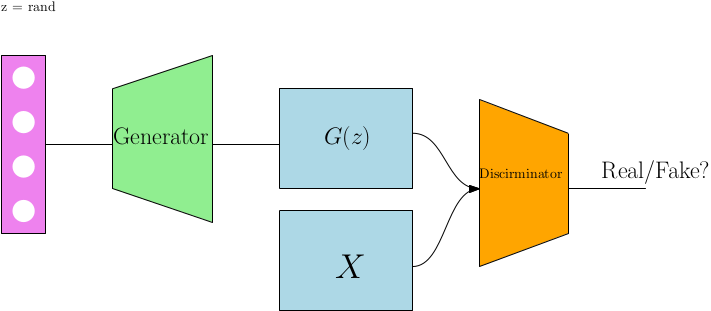

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt 
toimg = lambda x : x.reshape(28,28).detach().cpu().numpy()


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
bs = 100

# MNIST Dataset

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5),(0.5,))])


train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.EMNIST(root='./emnist_data/',split = 'byclass', train=False, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./emnist_data/EMNIST/raw/gzip.zip to ./emnist_data/EMNIST/raw


In [49]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [50]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [51]:
n_epoch = 200
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/200]: loss_d: 0.805, loss_g: 3.496
[2/200]: loss_d: 0.689, loss_g: 4.307
[3/200]: loss_d: 0.811, loss_g: 2.348
[4/200]: loss_d: 0.523, loss_g: 3.043
[5/200]: loss_d: 0.397, loss_g: 3.515
[6/200]: loss_d: 0.466, loss_g: 3.302
[7/200]: loss_d: 0.476, loss_g: 2.994
[8/200]: loss_d: 0.497, loss_g: 3.047
[9/200]: loss_d: 0.518, loss_g: 2.805
[10/200]: loss_d: 0.594, loss_g: 2.574
[11/200]: loss_d: 0.643, loss_g: 2.331
[12/200]: loss_d: 0.712, loss_g: 2.113
[13/200]: loss_d: 0.773, loss_g: 2.006
[14/200]: loss_d: 0.739, loss_g: 2.011
[15/200]: loss_d: 0.790, loss_g: 1.917
[16/200]: loss_d: 0.808, loss_g: 1.866
[17/200]: loss_d: 0.806, loss_g: 1.848
[18/200]: loss_d: 0.822, loss_g: 1.813
[19/200]: loss_d: 0.865, loss_g: 1.712
[20/200]: loss_d: 0.859, loss_g: 1.733
[21/200]: loss_d: 0.888, loss_g: 1.644
[22/200]: loss_d: 0.896, loss_g: 1.636
[23/200]: loss_d: 0.939, loss_g: 1.526
[24/200]: loss_d: 0.959, loss_g: 1.489
[25/200]: loss_d: 0.945, loss_g: 1.529
[26/200]: loss_d: 0.981, loss_g: 1

In [91]:
torch.save({'G' : G.state_dict(), 'D' : D.state_dict()}, 'trained_model.torch')

In [122]:
def anogan_z(x,G,D,l = 0.1, z0 = None, lr = 0.05, epochs = 500):
    if z0 is None:
        z0 = torch.randn((1,z_dim)).to(device)

    z = torch.autograd.Variable(z0,requires_grad = True).to(device)
    optimizer = optim.Adam([z], lr = lr)
    losses = []
    sigma = torch.tensor([[1.0]]).to(device)
    for epoch in range(epochs):
        g = G(z)
        loss = (1-l) * F.mse_loss(x,g) + l * F.binary_cross_entropy(D(g),sigma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return z, g, losses

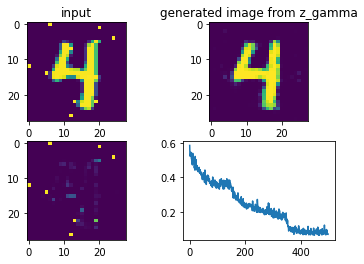

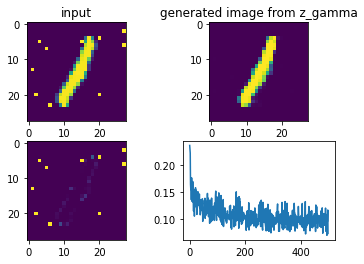

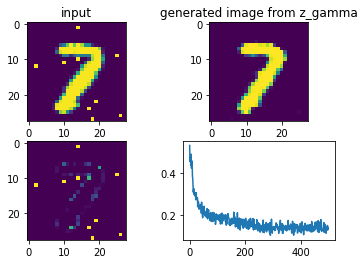

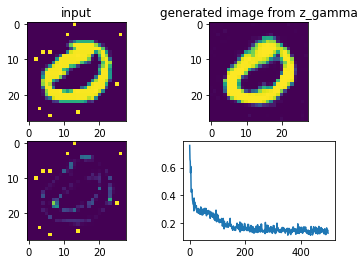

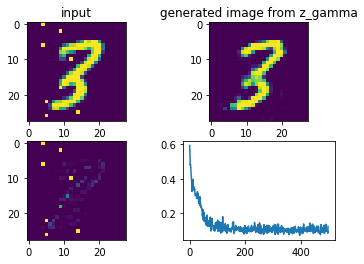

In [128]:
batch = next(iter(train_loader))[0]
# batch = next(iter(test_loader))[0]
 
for i in range(5):
    x = batch[i,0,...].reshape((1,-1)).to(device)
    x[0,np.random.randint(0,784,10)] = 1.0
    z,g, losses_ = anogan_z(x,G,D)
    plt.subplot(221)
    plt.title('input')
    plt.imshow(toimg(x))
    plt.subplot(222)
    plt.title('generated image from z_gamma')
    plt.imshow(toimg(g))
    plt.subplot(223)
    plt.imshow(toimg((g - x)** 2))
    plt.subplot(224)
    plt.plot(losses_)
    plt.show()

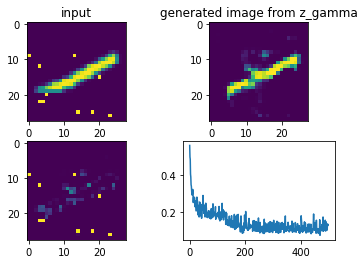

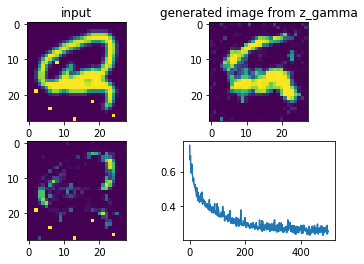

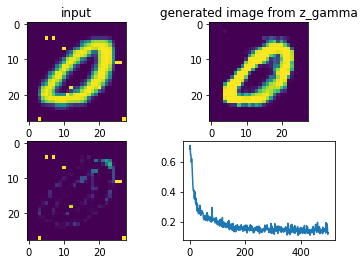

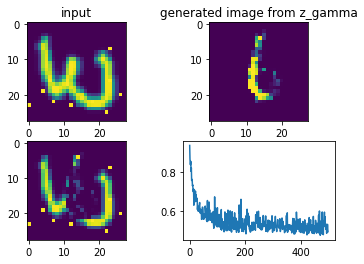

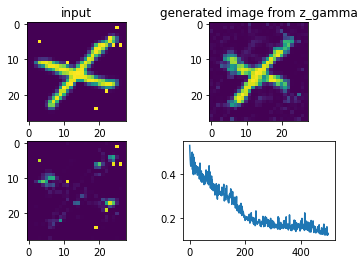

In [129]:
# batch = next(iter(train_loader))[0]
batch = next(iter(test_loader))[0]
 
for i in range(5):
    x = batch[i,0,...].reshape((1,-1)).to(device)
    x[0,np.random.randint(0,784,10)] = 1.0
    z,g, losses_ = anogan_z(x,G,D)
    plt.subplot(221)
    plt.title('input')
    plt.imshow(toimg(x))
    plt.subplot(222)
    plt.title('generated image from z_gamma')
    plt.imshow(toimg(g))
    plt.subplot(223)
    plt.imshow(toimg((g - x)** 2))
    plt.subplot(224)
    plt.plot(losses_)
    plt.show()